<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>



<CENTER>
</br>
<p><font size="5"> TAF MCE - 2021</span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  Julia lab - LMS Algorithm</font></p>
<p><font size="4">By Kevin Michalewicz - 07/12/2021</font></p>
</p></br>
</p>
</CENTER>

--------

# <span style="color:#00B8DE"> LMS equalization for digital data recovery </span>


> - 1  - Generate $n_s=10^4$ symbols of a BPSK modulation.
> - 2  - Convolve symbols with a filter with impulse response given by vector ${\bf h} \propto [1, .8, .3]$ and $\parallel {\bf h}\parallel = 1$. This filter represents the effect of propagation channel on transmitted symbols.
> - 3  - Add noise so as to achieve a fixed SNR at the receiver side. Plot the values of the first 20 symbols and that of the first 20 data samples as well as their sign for $SNR=20dB$. What do we note.
> - 4  - Check that even in the absence of noise the error probability $P_e$ resulting from decisions based on data thresholding would not be zero. Estimate the value of $P_e$ in the absence of equalization.
> - 5  - Implement an LMS filter with impulse response ${\bf w}$ of length $l_w=10$. The stepsize is set to half the maximum suggested stepsize and $SNR=20dB$.
> - 6  - plot the evolution of the distance $\parallel {\bf w}_{MSE}-{\bf w}_{LMS}\parallel $  between the $MSE$ estimate ${\bf w}_{MSE}$ of ${\bf w}$ and successsive LMS estimates $
{\bf w}_{LMS}$.
> - 7  - Study the convergence of the filter, depending on the SNR. 
> - 8  - Train the filter with $n_s=10^4$ symbols. Then generate data for $n_s=10^6$ symbols and $SNR=15dB$. Observe the histogram of data. Whate do you note?
> - 9  - deconvolve the sequence. Estimate the error probability $P_e$. Observe the histograms of equalizer output. remarks?
> - 10 - Analyze the influence of the different parameters (stepsize, SNR, impulse response ${\bf h}$, length of the training sequence, ...) on the behavior of the algorithm. 

## <span style="color:#00B8DE"> Data generation </span>

In [385]:
using LinearAlgebra: norm, tr
using Plots
pyplot()

Plots.PyPlotBackend()

In [386]:
using DSP
using Statistics
using StatsBase
using Noise
using ToeplitzMatrices
using LinearAlgebra

#1
n_s = 10^4 # 10^5 
input = rand([-1,1],n_s) # this line generates n_s symbols that are -1 or 1 (BPSK)

#2-3
SNR_dB = 20 # 55 # 5
h = [1,0.8,0.3] # [1,1,1] # [1,0.1,0.1]
h = h/norm(h) # we normalize h by dividing by its norm

output = conv(input,h)[1:n_s] # we get a n_s-element output
SNR = 10^(SNR_dB/10)
output_power = sum(output.*output)/length(output)
noise_power = output_power/SNR # it corresponds to the variance of the noise
noisy_output = add_gauss(output,sqrt(noise_power))

10000-element Vector{Float64}:
  0.71789410618387
 -0.10794469648383581
 -1.049208128209565
 -1.635689618265228
 -0.14530288148053738
 -0.4511935282722612
  0.4309921559003763
  1.248992402192798
  0.077355343197413
 -1.1564334519724273
 -0.1263797716085611
 -0.2963978570035387
 -1.2498469289257146
  ⋮
 -0.10241713426634907
  0.30734567774263216
  1.1014182461726485
  1.4988028117618868
  1.7154844908384919
  1.503743043313709
  0.03198478741837507
 -1.193192356458504
  0.09676491109634261
  1.21924457520295
  1.574752628430399
  0.07595892330339957

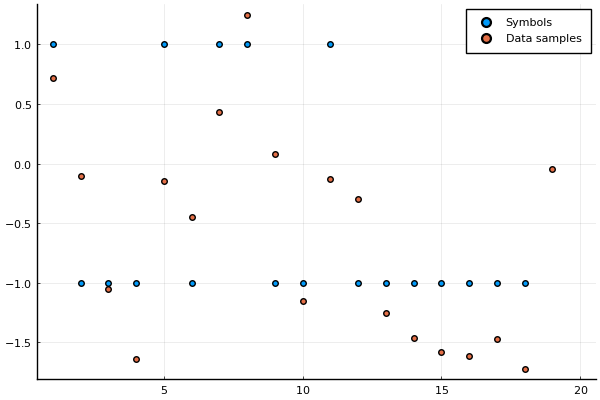

In [387]:
# Figures
scatter(input[1:20], label="Symbols")
scatter!(noisy_output[1:20], label="Data samples") # I've replaced noisy_output by output - case without noise

We note that decisions based on data thresholding would be wrong in some cases.

In [388]:
#4
data = noisy_output 
symb = input

print("Pe without equalization = $(sum((abs.(data-symb)).>1)/n_s)")

Pe without equalization = 0.1933

## <span style="color:#00B8DE"> LMS filter </span>

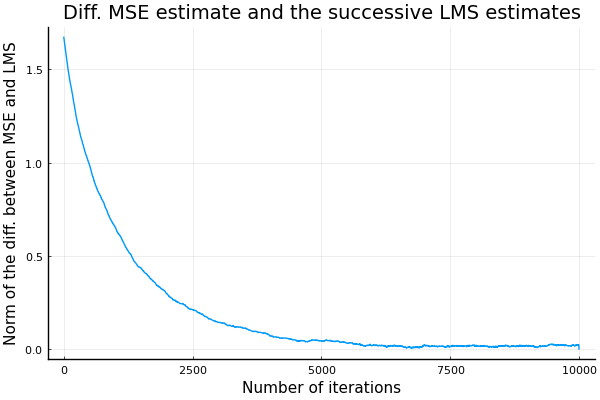

In [389]:
5#

# data
#-----
d = input
x = noisy_output

# Initialization of w
#--------------------
d = input
x = noisy_output
l_w = 10 # 20 # 5 # 2 # filter size
w_LMS = zeros(l_w)
flipped_x = zeros((n_s-l_w+1,l_w))
distance = zeros(n_s)

# MSE solution (min||w'.data-symb||)
#-----------------------------------

Rx = convert(Array{Float64,2}, SymmetricToeplitz(autocov(x)[1:l_w]))

for j = 1:n_s+1-l_w
    flipped_x[j,:] = reverse(x[j:j+l_w-1])
end

μ = 0.004 # 1/eigvals(Rx)[l_w] # 4*10^(-4) # less than a half of the maximum suggested stepsize

rx = flipped_x'*d[l_w:end]/n_s
w_MSE = inv(Rx)*rx

#LMS solution
#-------------
for j=1:n_s+1-l_w
    w_LMS = w_LMS - μ*flipped_x[j,:]*(flipped_x[j,:]'*w_LMS - d[j+l_w-1])
    distance[j] = norm(w_MSE - w_LMS)
end

# 6
plot(distance, title="Diff. MSE estimate and the successive LMS estimates", xlabel="Number of iterations", ylabel="Norm of the diff. between MSE and LMS", legend=false)

**Question 7:** A higher SNR (for instance, $55$ $dB$) will guarantee $\parallel {\bf w}_{MSE}-{\bf w}_{LMS}\parallel$ to converge in a smoother way, without many fluctuations. If we try with $5$ $dB$ the plotted norm will behave in a messy way and also $\bf w_{LMS}$ will be further away from $\bf w_{MSE}$ at the final iteration.

## <span style="color:#00B8DE"> Deconvolution </span>

In [390]:
# 8
# Equalizer design
w_LMS

10-element Vector{Float64}:
  1.273361524010891
 -0.9962793532735431
  0.4127349373743356
 -0.027249132858536414
 -0.07758600753675504
  0.07035406697438042
 -0.04361896369654224
  0.01423092725232322
  0.004716435930354267
 -0.003712742652247825

In [391]:
# Data generation
n_s = 10^6
input = rand([-1,1],n_s) # this line generates n_s symbols that are -1 or 1 (BPSK)
SNR_dB = 15
h = [1,0.8,0.3] 
h = h/norm(h) # we normalize h by dividing by its norm

output = conv(input,h)[1:n_s] # we get a n_s-element output
SNR = 10^(SNR_dB/10)
output_power = sum(output.*output)/length(output)
noise_power = output_power/SNR # it corresponds to the variance of the noise
noisy_output = add_gauss(output,sqrt(noise_power))

1000000-element Vector{Float64}:
 -0.7217463719623638
 -0.15859102520267504
  1.2728103967167441
  1.7682256338043385
  1.4746449165691482
  0.00579065533273751
  0.6112841053439335
  1.0850543490772426
  1.1841061818830667
  0.04843981103129892
 -0.8300824924251147
 -1.639433336193119
 -1.8096639601451174
  ⋮
 -1.50354492519735
 -1.342693987463372
 -0.026659426446508906
  1.3033425199202016
  0.016678305697962595
  0.3330309777298675
  0.9272777870368732
  1.681766391249521
 -0.2634744326020344
  0.3757870075054203
  1.2792319570840869
  1.6211535729376316

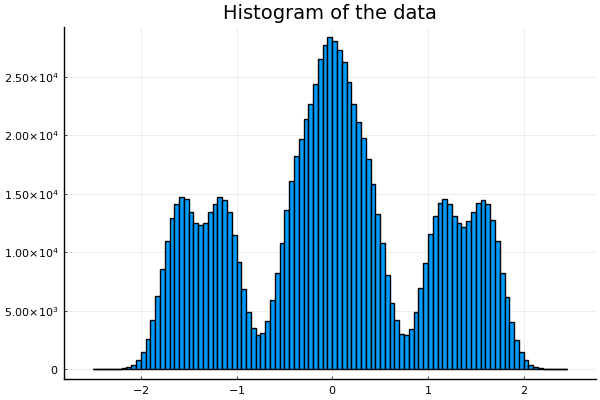

In [392]:
# data histogram
histogram(noisy_output, legend=false, title="Histogram of the data")

**Comment:** in the previous histogram we can see that the channel effect has distorted the actual generated data. Not only the peaks are not located around -1 and 1; thresholding will not work either.

In [393]:
# deconvolution
equalizer_output = conv(noisy_output, w_LMS)[1:n_s]

1000000-element Vector{Float64}:
 -0.9190440601513272
  0.517117299139662
  1.4808588069320092
  0.9377266749000281
  0.7017616141980221
 -0.8051325175749653
  1.254643439860168
  0.6838682135547074
  0.6277289384932631
 -0.6406215025240247
 -0.7256862439296538
 -1.289701971475919
 -1.056670018764414
  ⋮
 -0.6485497578593626
 -0.8064754205698511
  0.7761882165815842
  1.2433504803928637
 -1.2162673511412154
  0.999797710493588
  0.7743551036738424
  1.2834051267003668
 -1.567478376671953
  1.3272176339288302
  1.074130062630533
  0.8788352905629397

Pe with w_LMS equalization = 0.000815

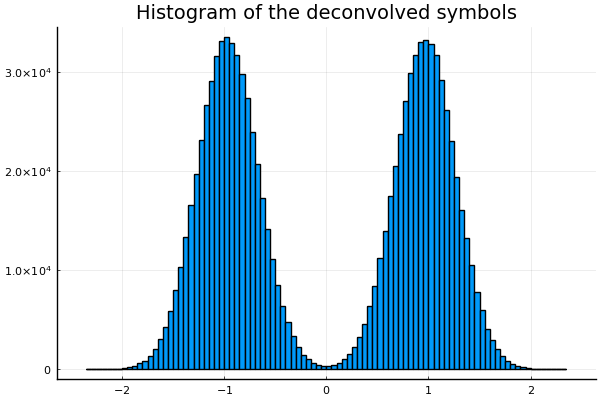

In [394]:
# Dhistogram of equalizer outputs
print("Pe with w_LMS equalization = $(sum((abs.(equalizer_output-input)).>1)/n_s)")
histogram(equalizer_output, legend=false, title="Histogram of the deconvolved symbols")


**Comment:** This case shows the opposite from the previous one. Thresholding (with value zero) could be used to distinguish -1 and 1 symbols after the equalization process.

## Exercise 10

The above code can be run with different stepsizes, SNRs, impulse responses and length of the training sequence. We comment the results in each case (check commented values in the code to know which values were tested):

- Stepsize $μ$: if it is too high, the algorithm "explodes". If it is too low, it may never converge given a certain number of iterations.

- SNR: in general it can be said that the higher the better (it can even reach zero, meaning that there are single vertical bins in -1 and 1). But if we perform the deconvolution with a given SNR that is distant from the one linked to the $\bf w_{LMS}$ parameters (training), then $P_e$ turns higher. 

- Impulse response: bad results are obtained if all the components of $h$ have the same magnitude. If just the first one has a significant weight, then the $\parallel {\bf w}_{MSE}-{\bf w}_{LMS}\parallel$ curve converges faster. Also, a high $l_w$ gives a smoother response than a lower value.

- Length of training sequence: if $n_s$ is higher the algorithm will give a lower $P_e$ and it will converge much faster. Despite that fact, it will take more time to run.